In [3]:
# working environment
!nvidia-smi

Sat Apr 15 19:41:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   47C    P8               38W / 390W|    258MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import the required libraries

In [19]:
import tensorflow as tf
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

# Download the datasets

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)
dataset_dir

'/root/.keras/datasets/flower_photos'

In [3]:
!ls /root/.keras/datasets/flower_photos

LICENSE.txt  daisy  dandelion  roses  sunflowers  tulips


In [5]:
CLASS_NAMES = [x for x in os.listdir(dataset_dir) if ".txt" not in x]
CLASS_NAMES

['sunflowers', 'tulips', 'dandelion', 'roses', 'daisy']

In [6]:
ds_meta = [{"name": x, "total": len(os.listdir(os.path.join(dataset_dir, x)))} for x in os.listdir(dataset_dir) if '.txt' not in x]

In [7]:
ds_meta

[{'name': 'sunflowers', 'total': 699},
 {'name': 'tulips', 'total': 799},
 {'name': 'dandelion', 'total': 898},
 {'name': 'roses', 'total': 641},
 {'name': 'daisy', 'total': 633}]

# Load the dataset using a dataset generator.

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_dir, label_mode="categorical", class_names=CLASS_NAMES, batch_size=None, image_size=(224, 224), seed=42, validation_split=0.2, shuffle=True, subset="training")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_dir, label_mode="categorical", class_names=CLASS_NAMES, batch_size=None, image_size=(224, 224), seed=42, validation_split=0.2, shuffle=True, subset="validation")

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-04-29 17:13:09.221081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 284 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
train = train_ds.batch(32).prefetch(tf.data.AUTOTUNE).cache()
test = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

2023-04-29 17:28:14.178930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-04-29 17:28:14.179201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]


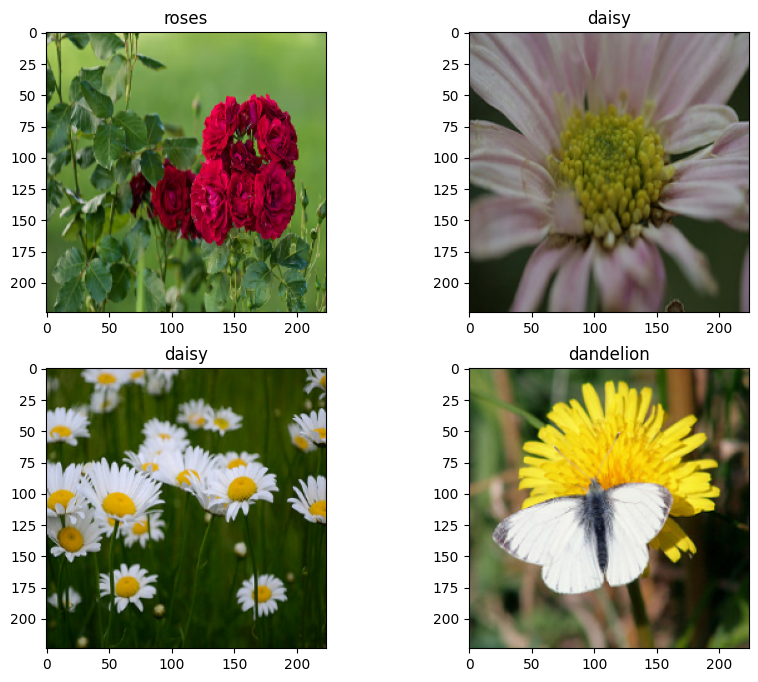

In [54]:
count = 0
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for x in train_ds.take(6):
    
    ax[count // 3, count % 2].imshow(x[0].numpy().astype(int))
    ax[count // 3, count % 2].set_title(CLASS_NAMES[x[1].numpy().argmax()])
    
    if count == 6:
        break
        
    count += 1

# Build the model

In [135]:
augment = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255.),
])

In [164]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = augment(inputs)
x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='valid')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_20 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_93 (Conv2D)          (None, 222, 222, 256)     7168      
                                                                 
 conv2d_94 (Conv2D)          (None, 220, 220, 256)     590080    
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 110, 110, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 108, 108, 256)     590080    
                                                          

# Train the model

In [165]:
history = model.fit(train, epochs=100, validation_data=test, validation_steps=len(test) * 0.25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)])

Epoch 1/100
92/92 [==============================] - 22s 223ms/step - loss: 2.1673 - accuracy: 0.2391 - val_loss: 1.6057 - val_accuracy: 0.2554
Epoch 2/100
92/92 [==============================] - 20s 222ms/step - loss: 1.5949 - accuracy: 0.2612 - val_loss: 1.5691 - val_accuracy: 0.2948
Epoch 3/100
92/92 [==============================] - 21s 223ms/step - loss: 1.4934 - accuracy: 0.3621 - val_loss: 1.3860 - val_accuracy: 0.3859
Epoch 4/100
92/92 [==============================] - 21s 223ms/step - loss: 1.3695 - accuracy: 0.3924 - val_loss: 1.3293 - val_accuracy: 0.4361
Epoch 5/100
92/92 [==============================] - 21s 224ms/step - loss: 1.3279 - accuracy: 0.4169 - val_loss: 1.2676 - val_accuracy: 0.4497
Epoch 6/100
92/92 [==============================] - 21s 224ms/step - loss: 1.2720 - accuracy: 0.4493 - val_loss: 1.1611 - val_accuracy: 0.4851
Epoch 7/100
92/92 [==============================] - 21s 225ms/step - loss: 1.1765 - accuracy: 0.5024 - val_loss: 1.0060 - val_accuracy:

# Save the model

In [166]:
model.save("saved_model.h5")

In [167]:
model.save_weights("saved_weights.h5")

# Load the model

In [168]:
loaded_model = tf.keras.models.load_model("saved_model.h5")

# Evaluate the model

<Axes: >

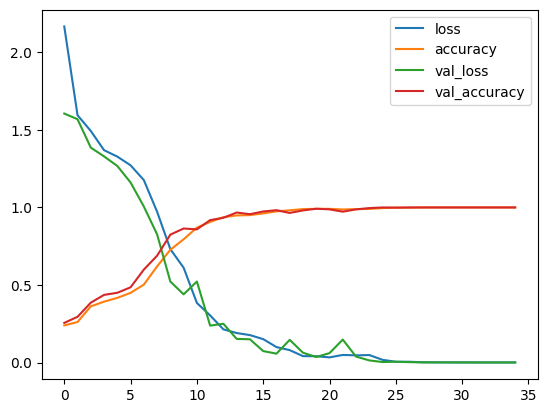

In [169]:
pd.DataFrame(history.history).plot()

In [170]:
evaluate = model.evaluate(test)
print("Testing accuracy:", evaluate[1])

92/92 [==============================] - 9s 93ms/step - loss: 2.4239e-04 - accuracy: 1.0000
Testing accuracy: 1.0


# Plot the confusion matrix

In [177]:
def conf_matrix(y_test=None, y_pred=None, class_names=None):
    
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    a = ax.matshow(cm, cmap=plt.cm.Greens)  
    
    fig.colorbar(a)  
    
    ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="Actual label",
             xticks=np.arange(len(class_names)), 
             yticks=np.arange(len(class_names)), 
             xticklabels=class_names,  
             yticklabels=class_names)
    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=60, fontsize=20)
    plt.yticks(fontsize=20)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center", color="black" if cm[i, j] < (cm.max() + cm.min()) / 2 else "white",
                  fontsize=20)

In [172]:
y_pred = []
y_truth = []

for x, y in test:
    y_pred.extend(model.predict([x], verbose=0).argmax(axis=1))
    y_truth.extend(y.numpy().argmax(axis=1))

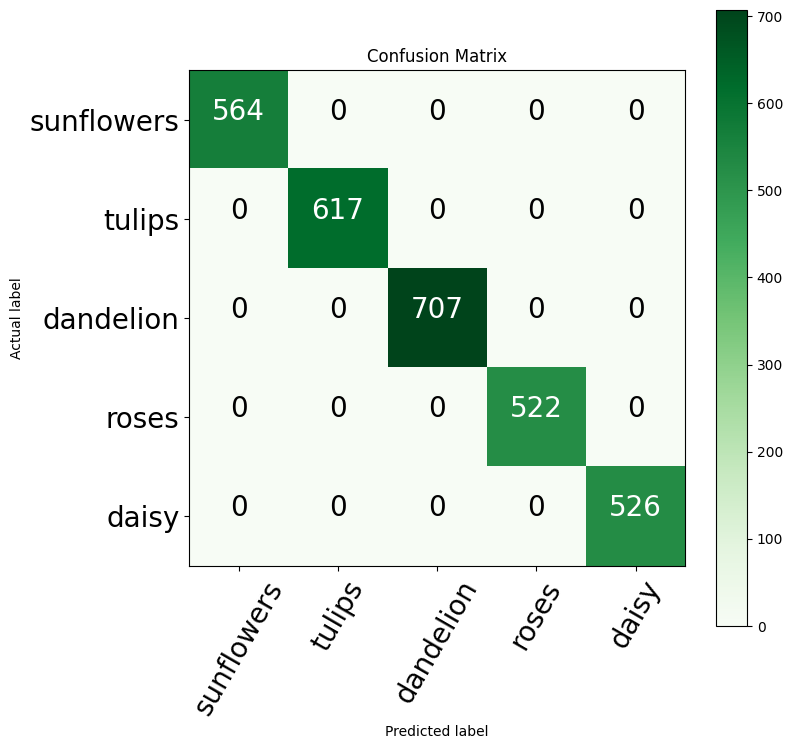

In [178]:
conf_matrix(y_test=y_truth, y_pred=y_pred, class_names=CLASS_NAMES)